Generate a graph showing 5v5 rolling SACF% for each player in lineup.
<p>First, import relevant packages and routines, and import seaborn to use its nicer-looking default aesthetic settings.

In [1]:
import PbPMethods2 as pm2
from pylab import *
%matplotlib inline
import pandas as pd
import GetPbP
import matplotlib.patheffects as path_effects
import seaborn
from matplotlib.dates import DateFormatter
import datetime

Read in game-by-game data from 07-08 to present.

In [2]:
dfs = []
for season in range(2007, 2017):
    dfs.append(pd.read_csv(pm2.get_gamebygame_data_filename(season)))
dfs = pd.concat(dfs)
#dfs.head()

Set parameters:
<ul>
<li>player--player name. You may have to try a few different variations before it works.
<li>player position--D or F
<li>start date and end date--in yyyy-mm-dd format
<li>teams--relevant teams, or "all"
<li>roll length for GF% (and shooting percentage) graph
<li>roll length for CF% graph 
<li>roll length for the boxcar graph
<li>boolean for whether to include the playoffs
<li>filename to save to file, or "None" to simply display
<li>boolean for whether to index the x-axis on date (False) or game number (True)--former will result in horizontal lines over July, August, and September, which are a little ugly but make it easy to note offseasons
<li>boolean for whether boxcars should be rate stats or totals


In [3]:
lineup = {'L1': ['Alex Ovechkin', 'Nicklas Backstrom', 'TJ Oshie'],
          'L2': ['Marcus Johansson', 'Evgeny Kuznetsov', 'Justin Williams'],
          'L3': ['Brett Connolly', 'Lars Eller', 'Andre Burakovsky'],
          'L4': ['Daniel Winnik', 'Jay Beagle', 'Tom Wilson'],
          'LX': ['Jakub Vrana'],
          'P1': ['Dmitry Orlov', 'Matt Niskanen'],
          'P2': ['Karl Alzner', 'John Carlson'],
          'P3': ['Brooks Orpik', 'Kevin Shattenkirk'],
          'PX': ['Nate Schmidt']}
players = set()
for line in lineup:
    for p in lineup[line]:
        players.add(p)
start_date = '2016-09-15' #use mid-Sept to be safe because some seasons have Euro premiere games
end_date = '2017-06-21' #Format: yyyy-mm-dd

teams = 'all' #or, e.g. {'WSH'}, or {'WSH', 'T.B'}

include_playoffs = True #can also set to False
save_file = None

if teams == 'all':
    teams = GetPbP.TEAMS
if isinstance(teams, str):
    teams = {teams}

Filters down all the game-by-game data to the one fulfilling the player, team, and date requirements.

In [4]:
dfs['Qualifying Player'] = dfs.Player.apply(lambda x: x in players)
df = dfs[dfs['Qualifying Player'] == True]
df = df[df.Team.apply(lambda x: x in teams)]

df['Date2'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.sort_values('Date2', inplace=True)
df.set_index('Date2', inplace=True)
df = df.ix[start_date : end_date]

if not include_playoffs:
    df = df[df.Game <= 21230]
    
df.loc[0:len(df), 'Cumulative SACF'] = df.groupby('Player')['SACFON'].cumsum()
df.loc[0:len(df), 'Cumulative SACA'] = df.groupby('Player')['SACAON'].cumsum()
df.loc[0:len(df), 'Cumulative SACFOFF'] = df.groupby('Player')['SACFOFF'].cumsum()
df.loc[0:len(df), 'Cumulative SACAOFF'] = df.groupby('Player')['SACAOFF'].cumsum()
df.loc[0:len(df), 'Cumulative TOION'] = df.groupby('Player')['TOION(60s)'].cumsum()
df.loc[0:len(df), 'Cumulative TOIOFF'] = df.groupby('Player')['TOIOFF(60s)'].cumsum()

df.loc[0:len(df), 'Cumulative SAC On +/-'] = (df['Cumulative SACF'] - df['Cumulative SACA'])/df['Cumulative TOION']
df.loc[0:len(df), 'Cumulative SAC Off +/-'] = (df['Cumulative SACFOFF'] - df['Cumulative SACAOFF'])/df['Cumulative TOIOFF']

Helper method for reformatting date stamps.

In [5]:
def format_timestamp_as_mdyy(ts):
    st = str(ts).split(' ')[0]
    y, m, d = st.split('-')
    m = int(m)
    d = int(d)
    return '{0:d}/{1:d}\n{2:s}'.format(m, d, y)
def format_dd_mmm_yy_as_mdyy(string):
    day, month, year = string.split('-')
    m = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 
         'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}[month]
    return '{0:d}/{1:d}/{2:s}'.format(m, int(day), year)

Plot.

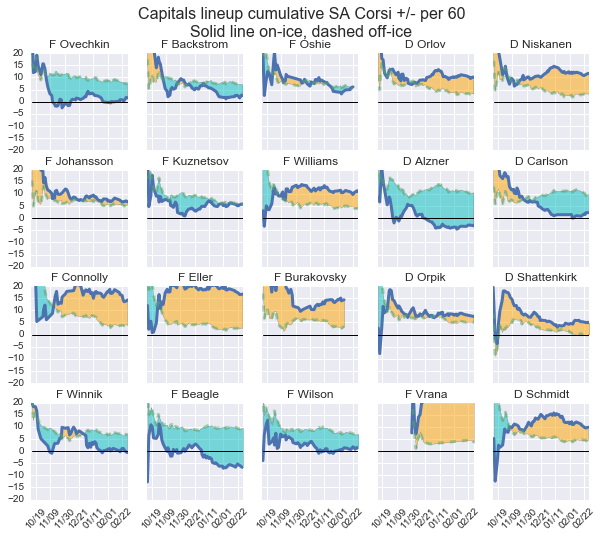

In [6]:
fig, axes = subplots(4, 5, sharex = True, sharey = True, figsize=[10, 8])
formatter = DateFormatter('%m/%d')
#xticks(rotation=30)
for line in range(4):
    line2 = 'L' + str(line + 1)
    for i, player in enumerate(lineup[line2]):
        temp = df[df.Player == player]
        x = temp['Date']
        yon = temp['Cumulative SAC On +/-']
        yoff = temp['Cumulative SAC Off +/-']
        ax = axes[line, i]

        ax.plot(yon, lw=3, label='On ice')

        ax.plot(yoff, lw=3, label='Off ice', ls='--', alpha=0.5)
        ax.plot(xlim(), [0, 0], lw = 1, color = 'k', label = 'Average')
        ax.fill_between(temp.index, yon, yoff, where = yon >= yoff, facecolor = 'orange', alpha = 0.5, interpolate = True)
        ax.fill_between(temp.index, yon, yoff, where = yon < yoff, facecolor = 'c', alpha = 0.5, interpolate = True)
        ax.set_title('F {0:s}'.format(player.split(' ', 1)[1]))
        ax.xaxis.set_major_formatter(formatter)
        labels = ax.get_xticklabels()
        setp(labels, rotation=45, fontsize=10)
        ax.set_ylim(-20, 20)
        
for pair in range(3):
    pair2 = 'P' + str(pair + 1)
    for i, player in enumerate(lineup[pair2]):
        temp = df[df.Player == player]
        x = temp['Date']
        yon = temp['Cumulative SAC On +/-']
        yoff = temp['Cumulative SAC Off +/-']
        ax = axes[pair, i + 3]

        ax.plot(yon, lw=3, label='On ice')

        ax.plot(yoff, lw=3, label='Off ice', ls='--', alpha=0.5)
        ax.plot(xlim(), [0, 0], lw = 1, color = 'k', label = 'Average')
        ax.fill_between(temp.index, yon, yoff, where = yon >= yoff, facecolor = 'orange', alpha = 0.5, interpolate = True)
        ax.fill_between(temp.index, yon, yoff, where = yon < yoff, facecolor = 'c', alpha = 0.5, interpolate = True)
        ax.set_title('D {0:s}'.format(player.split(' ', 1)[1]))
        ax.xaxis.set_major_formatter(formatter)
        labels = ax.get_xticklabels()
        setp(labels, rotation=45, fontsize=10)
        ax.set_ylim(-20, 20)

for xtra in [('L', 'F'), ('P', 'D')]:
    player = lineup[xtra[0] + 'X'][0]
    temp = df[df.Player == player]
    x = temp['Date']
    yon = temp['Cumulative SAC On +/-']
    yoff = temp['Cumulative SAC Off +/-']
    if xtra[0] == 'L':
        ax = axes[3, 3]
    else:
        ax = axes[3, 4]

    ax.plot(yon, lw=3, label='On ice')

    ax.plot(yoff, lw=3, label='Off ice', ls='--', alpha=0.5)
    ax.plot(xlim(), [0, 0], lw = 1, color = 'k', label = 'Average')
    ax.fill_between(temp.index, yon, yoff, where = yon >= yoff, facecolor = 'orange', alpha = 0.5, interpolate = True)
    ax.fill_between(temp.index, yon, yoff, where = yon < yoff, facecolor = 'c', alpha = 0.5, interpolate = True)
    ax.set_title('{1:s} {0:s}'.format(player.split(' ', 1)[1], xtra[1]))
    ax.xaxis.set_major_formatter(formatter)
    labels = ax.get_xticklabels()
    setp(labels, rotation=45, fontsize=10)
    ax.set_ylim(-20, 20)
figtitle = 'Capitals lineup cumulative SA Corsi +/- per 60'
figtitle += '\nSolid line on-ice, dashed off-ice'
fig.suptitle(figtitle, fontsize = 16)